<a href="https://colab.research.google.com/github/IssacChew/Japanese-Handwritting-Recognition/blob/main/FYP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!ls "/content/MyDrive/MyDrive/Japanese Handwritting Recognition"

ETL8B  Handwritten-Japanese-Recognition-master	kanji


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import numpy as np 
import pandas as pd
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import collections
from collections import defaultdict
import skimage.transform
from sklearn.model_selection import train_test_split

import time
import copy

import struct
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Read Katakana
def read_record_ETL1G(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('P')
    return r + (iL,)

def read_kana():
    katakana = np.zeros([51, 1411, 63, 64], dtype=np.uint8) # 51 characters, 1411 writers, img size = 63*64
    for i in range(7,14):
        filename = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Handwritten-Japanese-Recognition-master/ETL1/ETL1C_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            if i!=13: # file 13 only has 3 characters, others have 8 characters
                limit = 8
            else:
                limit=3
            for dataset in range(limit):
                for j in range(1411):
                    try :
                        r = read_record_ETL1G(f)
                        katakana[(i - 7) * 8 + dataset, j] = np.array(r[-1])
                    except struct.error: # two imgs are blank according to the ETL website, so this prevents any errors
                        pass
    np.savez_compressed("kana.npz", katakana)

In [ ]:
read_kana()

In [ ]:
#Preprocess katakana
kana = np.load("kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

# make the numbers range from 0 to 1
kana = kana/np.max(kana)

# 51 is the number of different katakana (3 are duplicates so in the end there are 48 classes)
# 1411 writers
# transform the size of images to 48*48
train_images = np.zeros([51 * 1411, 48, 48], dtype=np.float32)

for i in range(51 * 1411): # change the image size to 48*48
    train_images[i] = skimage.transform.resize(kana[i], (48, 48))

# create labels
arr = np.arange(51)
train_labels = np.repeat(arr, 1411)

# give the duplicates the same labels
for i in range(len(train_labels)):
	if train_labels[i] == 36:
		train_labels[i] = 1
	elif train_labels[i] == 38:
		train_labels[i] = 3
	elif train_labels[i] == 47:
		train_labels[i] = 2
	elif train_labels[i] == 37:
		train_labels[i] = train_labels[i] -1
	elif train_labels[i] >= 39 and train_labels[i] <= 46:
		train_labels[i] = train_labels[i] - 2
	elif train_labels[i] >= 48:
		train_labels[i] = train_labels[i] -3

delete = [] # the 33863th and 67727th images are blank, so we delete them
for i in range(len(train_images)):
	if (train_images[i] == np.zeros([train_images[i].shape[0],train_images[i].shape[1]],dtype=np.uint8) ).all():
		delete.append(i)

train_images = np.delete(train_images,delete[0],axis=0)
train_labels = np.delete(train_labels,delete[0])

train_images = np.delete(train_images,delete[1]-1,axis=0)
train_labels = np.delete(train_labels,delete[1]-1)

# split the images/labels to train and test
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2)

np.savez_compressed("katakana_train_images.npz", train_images)
np.savez_compressed("katakana_train_labels.npz", train_labels)
np.savez_compressed("katakana_test_images.npz", test_images)
np.savez_compressed("katakana_test_labels.npz", test_labels)

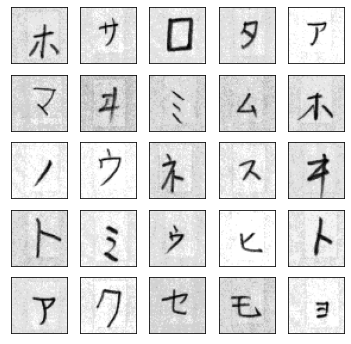

In [ ]:
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
#CNN Katakana
train_images = np.load("katakana_train_images.npz")['arr_0']
train_labels = np.load("katakana_train_labels.npz")['arr_0']
test_images = np.load("katakana_test_images.npz")['arr_0']
test_labels = np.load("katakana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first": # reshape the image to be able to go through 2D CNN
  train_images = train_images.reshape(train_images.shape[0], 1,48,48)
  test_images2 = test_images.reshape(test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  train_images = train_images.reshape(train_images.shape[0], 48, 48, 1)
  test_images2 = test_images.reshape(test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)

# the model
datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(train_images)
model = keras.Sequential([
  keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(48, activation="softmax")
])

In [ ]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=30,validation_data=(test_images2,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
1799/1799 [==============================] - 208s 115ms/step - loss: 0.9025 - accuracy: 0.7441 - val_loss: 0.1720 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 2/30
1799/1799 [==============================] - 207s 115ms/step - loss: 0.3355 - accuracy: 0.9031 - val_loss: 0.1329 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 3/30
1799/1799 [==============================] - 206s 114ms/step - loss: 0.2529 - accuracy: 0.9284 - val_loss: 0.1107 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 4/30
1799/1799 [==============================] - 205s 114ms/step - loss: 0.2117 - accuracy: 0.9399 - val_loss: 0.1046 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 5/30
1799/1799 [==============================] - 204s 113ms/step - loss: 0.1879 - accuracy: 0.9471 - val_loss: 0.0997 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 6/30
1799/1799 [==============================] - 204s 113ms/step - loss: 0.1736 - accuracy: 0.9522 - val_loss: 0.1000 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 7/30
1799/1799 [============

In [ ]:
model.save("katakana-model.h5") 

In [ ]:
keras.models.load_model("katakana-model.h5")
model.summary()
model.evaluate(test_images,test_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

[0.07018914818763733, 0.9867982268333435]

In [ ]:
#Read Hiragana
def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_hira():
    hiragana = np.zeros([71, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Handwritten-Japanese-Recognition-master/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                            char += 1
    np.savez_compressed("hiragana.npz", hiragana)
    


In [ ]:
read_hira()

In [ ]:
#Preprocess Hiragana
hira = np.load("hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

hira = hira/np.max(hira)

# 71 characters, 160 writers, transform image to 48*48
hira_train_images = np.zeros([71 * 160, 48, 48], dtype=np.float32)

for i in range(71 * 160):
    hira_train_images[i] = skimage.transform.resize(hira[i], (48, 48))

arr = np.arange(71)
hira_train_labels = np.repeat(arr, 160) # create labels

# split to train and test
hira_train_images, hira_test_images, hira_train_labels, hira_test_labels = train_test_split(hira_train_images, hira_train_labels, test_size=0.2)

np.savez_compressed("hiragana_train_images.npz", hira_train_images)
np.savez_compressed("hiragana_train_labels.npz", hira_train_labels)
np.savez_compressed("hiragana_test_images.npz", hira_test_images)
np.savez_compressed("hiragana_test_labels.npz", hira_test_labels)


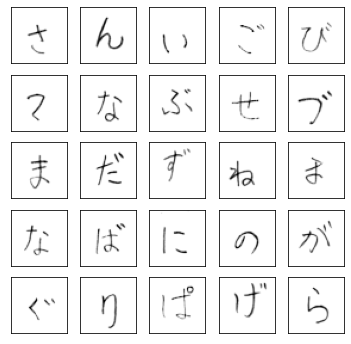

In [ ]:
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(hira_train_images[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
hira_train_images = np.load("hiragana_train_images.npz")['arr_0']
hira_train_labels = np.load("hiragana_train_labels.npz")['arr_0']
hira_test_images = np.load("hiragana_test_images.npz")['arr_0']
hira_test_labels = np.load("hiragana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  hira_train_images = hira_train_images.reshape(hira_train_images.shape[0], 1,48,48)
  hira_test_images2 = hira_test_images.reshape(hira_test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  hira_train_images = hira_train_images.reshape(hira_train_images.shape[0], 48, 48, 1)
  hira_test_images2 = hira_test_images.reshape(hira_test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)

datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(hira_train_images)

hira_model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dense(71, activation="softmax")
])


#test_loss, test_acc = model.evaluate(hira_test_images2, hira_test_labels)
#print("Test Accuracy: ", test_acc)



In [ ]:
hira_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
hira_model.fit_generator(datagen.flow(hira_train_images,hira_train_labels,shuffle=True),epochs=30,
                         validation_data=(hira_test_images2,hira_test_labels),
                         callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
284/284 [==============================] - 54s 190ms/step - loss: 2.2372 - accuracy: 0.4181 - val_loss: 0.6561 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 2/30
284/284 [==============================] - 54s 189ms/step - loss: 0.8261 - accuracy: 0.7449 - val_loss: 0.3942 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 3/30
284/284 [==============================] - 54s 190ms/step - loss: 0.5885 - accuracy: 0.8159 - val_loss: 0.2495 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 4/30
284/284 [==============================] - 54s 189ms/step - loss: 0.4418 - accuracy: 0.8594 - val_loss: 0.1877 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 5/30
284/284 [==============================] - 54s 189ms/step - loss: 0.3545 - accuracy: 0.8825 - val_loss: 0.1470 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 6/30
284/284 [==============================] - 54s 189ms/step - loss: 0.3008 - accuracy: 0.9028 - val_loss: 0.1093 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 7/30
284/284 [==============================] 

In [ ]:
hira_model.save("hiragana-model.h5")

In [ ]:
keras.hira_models.load_model("hiragana-model.h5")
hira_model.summary()
hira_model.evaluate(hira_test_images,hira_test_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

[0.413323312997818, 0.887993335723877]

In [ ]:
#Read Kanji
def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_kanji():
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Handwritten-Japanese-Recognition-master/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed("kanji.npz", kanji)



In [ ]:
read_kanji()

In [ ]:
#Preprocess Kanji
kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

kan_train_images = np.zeros([879 * 160, 48, 48], dtype=np.float32)

arr = np.arange(879)
kan_train_labels = np.repeat(arr, 160)

# 4 characters were actually hiragana, so delete these 4 extras
for i in range( (879+4) * 160):
	if int(i/160) != 88 and int(i/160) != 219 and int(i/160) != 349 and int(i/160) != 457:
		if int(i/160) < 88:
			kan_train_images[i] = skimage.transform.resize(kan[i], (48, 48))
		if int(i/160) > 88 and int(i/160) < 219:
			kan_train_images[i-160] = skimage.transform.resize(kan[i], (48, 48))
		if int(i/160) > 219 and int(i/160) < 349:
			kan_train_images[i-320] = skimage.transform.resize(kan[i], (48, 48))
		if int(i/160) > 349 and int(i/160) < 457:
			if int(i/160) > 457:
				kan_train_images[i-640] = skimage.transform.resize(kan[i], (48, 48))
      
kan_train_images, kan_test_images, kan_train_labels, kan_test_labels = train_test_split(kan_train_images, kan_train_labels, test_size=0.2)

np.savez_compressed("kanji_train_images.npz", kan_train_images)
np.savez_compressed("kanji_train_labels.npz", kan_train_labels)
np.savez_compressed("kanji_test_images.npz", kan_test_images)
np.savez_compressed("kanji_test_labels.npz", kan_test_labels)

In [ ]:
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kan_train_images[i], cmap=plt.cm.binary)
plt.show()

NameError: ignored

In [ ]:
kan_train_images = np.load("kanji_train_images.npz")['arr_0']
kan_train_labels = np.load("kanji_train_labels.npz")['arr_0']
kan_test_images = np.load("kanji_test_images.npz")['arr_0']
kan_test_labels = np.load("kanji_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  kan_train_images = kan_train_images.reshape(kan_train_images.shape[0], 1,48,48)
  kan_test_images = kan_test_images.reshape(kan_test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  kan_train_images = kan_train_images.reshape(kan_train_images.shape[0], 48, 48, 1)
  kan_test_images = kan_test_images.reshape(kan_test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)
  
datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(kan_train_images)
kan_model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(879, activation="softmax")
])


#test_loss, test_acc = model.evaluate(test_images, test_labels)
#print("Test Accuracy: ", test_acc)


In [ ]:
kan_model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])


In [ ]:
kan_model.fit_generator(datagen.flow(kan_train_images,kan_train_labels,shuffle=True),epochs=50,
                        validation_data=(kan_test_images,kan_test_labels),
                        callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),
                                     keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


In [ ]:
model.save("kanji-model.h5")

In [ ]:
keras.kan_models.load_model("kan-model.h5")
hira_model.summary()
hira_model.evaluate(kan_test_images,kan_test_labels)